NOTA: Este notebook solo contiene codigo para explorar alternativas de estimación de la demanda.

La idea es identificar el algoritmo que mejor se adapta a cada situación y hacer una evaluación de su accuracy.

Haremos las evaluaciónes importando directamente los datos desde la BD y guardando un cache local en modo csv

# IMPORTACIONES BÁSICAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyodbc
from dotenv import dotenv_values

# CARGAR DATOS DE LA DEMANDA

In [2]:
# OBTENER PARÁMETROS de la CONEXIÓN
secrets = dotenv_values(".env")
local_secrets = dotenv_values(".env.dev")

DRIVER = secrets["DRIVER2"]
SERVIDOR = secrets["SERVIDOR2"]
PUERTO = secrets["PUERTO2"]
BASE = secrets["BASE2"]
USUARIO = secrets["USUARIO2"]
CONTRASENA = secrets["CONTRASENA2"]

conn_str = f'DRIVER={DRIVER};SERVER={SERVIDOR};PORT={PUERTO};DATABASE={BASE};UID={USUARIO};PWD={CONTRASENA}'

print (conn_str)

DRIVER={ODBC Driver 17 for SQL Server};SERVER=10.54.200.90;PORT=1433;DATABASE=data-sync;UID=eettlin;PWD=lOc4l_eXt$24;


### Cargar Datos de las Sucursales


In [3]:
import chardet

with open('data/Sucursales.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result['encoding'])  # Muestra la codificación detectada

# Cargar el archivo con codificación UTF-8
sucursales = pd.read_csv('data/Sucursales.csv', encoding='utf-8', sep=';')

# Visualización de las primeras filas\
sucursales.head()

UTF-8-SIG


,id_tienda,suc_nombre,suc_abr,cluster,formato,label,dirección
0,1.0,MERCADO_CENTRAL,MC,GBA,MAYORISTA,M001_Mercado_Central,Mercado_Central
1,2.0,POSADAS,PO,INTERIOR 1,MAYORISTA,M002_Posadas,Posadas
2,3.0,TRELEW,TR,INTERIOR 1,MAYORISTA,M003_Trelew,Trelew
3,4.0,CASANOVA,NaN,NaN,MAYORISTA,M004_Casanova,Casanova
4,5.0,SAN_MARTIN,SM,GBA,MAYORISTA,M005_San_Martin,San_Martin


### CARGAR DATOS DE VENTA DEL PROVEEDOR de TODAS LAS SUCURSALES

### PROVEEDORES


*   20 - MOLINOS RIO DE LA PLATA
*   25 - CAFES LA VIRGINIA S.A.                            
*   62 - ARCOR
*   98 - FRATELLI BRANCA DESTILERIAS S.A.  
*  140 - UNILEVER DE ARGENTINA S.A.
*  189 - BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.    
* 1465 - QUICKFOOD S.A.             
*  327 - PALADINI S.A.                                     
                                                                                      

In [4]:
# ELEGIR el PROVEEDOR

proveedor = 327
label = '327-Paladini'

In [7]:
# Configuración de conexión
conn_str = f'DRIVER={DRIVER};SERVER={SERVIDOR};PORT={PUERTO};DATBASE={BASE};UID={USUARIO};PWD={CONTRASENA}'

conn = pyodbc.connect(conn_str)

# Consulta SQL para obtener las ventas de un proveedor específico   
# Reemplazar {proveedor} en la consulta con el ID de la tienda actual
query = f"""
SELECT V.[F_VENTA] as Fecha
     ,V.[C_ARTICULO] as Codigo_Articulo
     ,V.[C_SUCU_EMPR] as Sucursal
     ,V.[I_PRECIO_VENTA] as Precio
     ,V.[I_PRECIO_COSTO] as Costo
     ,V.[Q_UNIDADES_VENDIDAS] as Unidades
     ,V.[C_FAMILIA] as Familia
     ,A.[C_RUBRO] as Rubro
     ,A.[C_SUBRUBRO_1] as SubRubro
     ,A.[N_ARTICULO] as Nombre_Articulo
     ,A.[C_CLASIFICACION_COMPRA] as Clasificacion
FROM [DCO-DBCORE-P02].[DiarcoEst].[dbo].[T702_EST_VTAS_POR_ARTICULO] V
LEFT JOIN [DCO-DBCORE-P02].[DiarcoEst].[dbo].[T050_ARTICULOS] A 
     ON V.C_ARTICULO = A.C_ARTICULO
WHERE A.[C_PROVEEDOR_PRIMARIO] = {proveedor} AND V.F_VENTA >= '20210101' AND A.M_BAJA ='N'
ORDER BY V.F_VENTA ;
"""

# Ejecutar la consulta SQL
data = pd.read_sql(query, conn)

# Guardar los resultados en un archivo CSV con el nombre de la tienda
file_path = f'data/{label}.csv'
data.to_csv(file_path, index=False, encoding='utf-8')

print(f"Archivo guardado: {file_path}")

# Cerrar la conexión después de la iteración
conn.close()

C:\Users\eduar\AppData\Local\Temp\ipykernel_28952\1559501214.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


Archivo guardado: data/327-Paladini.csv


# DATASET PARA ALGORITMOS SUPERVISADOS

## CARGA DEL FICHERO desde el CSV

In [ ]:
data = pd.read_csv(f'data/{label}.csv')
data.head()

In [8]:
# Adecuar Tipos de Datos
data['Sucursal']= data['Sucursal'].astype(int)
data['Familia']= data['Familia'].astype(int)
data['Rubro']= data['Rubro'].astype(int)
data['SubRubro']= data['SubRubro'].astype(int)
data['Clasificacion']= data['Clasificacion'].astype(int)
data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)

data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a formato datetime si aún no lo está
data.sort_values(by='Fecha', ascending=True)  # Ordenar por fecha de menor a mayor

# Crear una nueva columna con el mes y el año para análisis temporal
data['Año-Mes'] = data['Fecha'].dt.to_period('M')

# Crear una nueva columna con el formato Año-Semana (AAAA-WW) a partir de la columna Fecha
data['Año-Semana'] = data['Fecha'].dt.strftime('%Y-%W')

# Confirmar que la columna sigue siendo un campo datetime
#print(data.dtypes)

#data = data.sort_values(by='Fecha', ascending=True)  # Ordenar en orden ascendente (del más antiguo al más reciente)
#data = data.reset_index()

In [10]:
# Agregar FORMATO de la Tienda

# Asegurar que la columna 'Sucursal' en data y 'id_tienda' en sucursales sean del mismo tipo
data['Sucursal'] = data['Sucursal'].astype(int)
sucursales['id_tienda'] = sucursales['id_tienda'].astype(int)

# Fusionar los DataFrames para agregar el campo 'formato' al DataFrame 'data'
data = data.merge(sucursales[['id_tienda', 'formato']], left_on='Sucursal', right_on='id_tienda', how='left')

# # Eliminar la columna 'id_tienda' después del merge si ya no es necesaria
# data.drop(columns=['id_tienda'], inplace=True)

data.head()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296440 entries, 0 to 296439
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Fecha            296440 non-null  datetime64[ns]
 1   Codigo_Articulo  296440 non-null  int64         
 2   Sucursal         296440 non-null  int64         
 3   Precio           296440 non-null  float64       
 4   Costo            296440 non-null  float64       
 5   Unidades         296440 non-null  float64       
 6   Familia          296440 non-null  int64         
 7   Rubro            296440 non-null  int64         
 8   SubRubro         296440 non-null  int64         
 9   Nombre_Articulo  296440 non-null  object        
 10  Clasificacion    296440 non-null  int64         
 11  Año-Mes          296440 non-null  period[M]     
 12  Año-Semana       296440 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(6), object(2), period[M](1)
memory

In [12]:
# Recortar Cantidad de Datos ULTIMO AÑO COMPLETO
data = data[data['Fecha']>='2022-01-01']

### Explorar los Datos

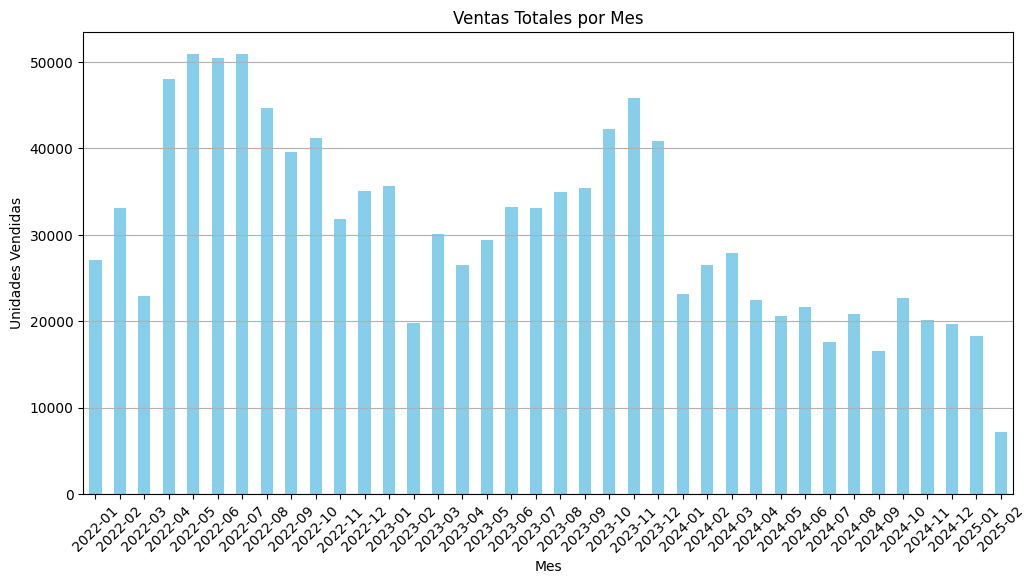

<Figure size 1200x600 with 0 Axes>

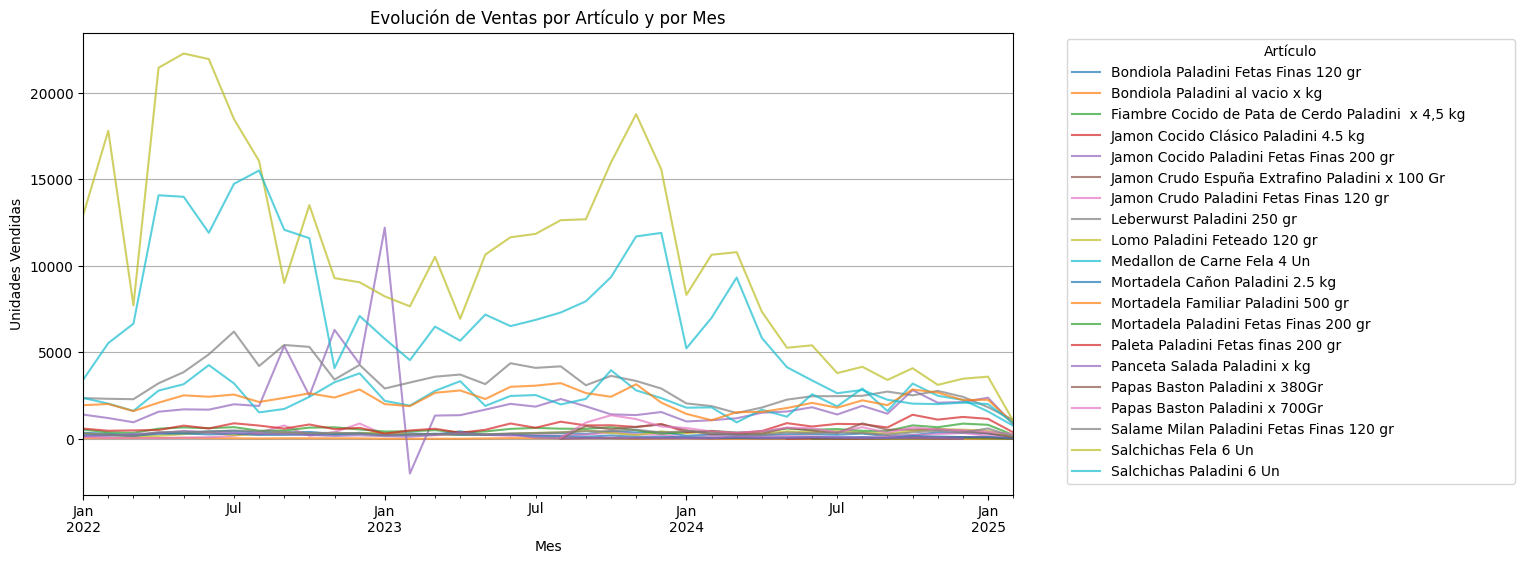

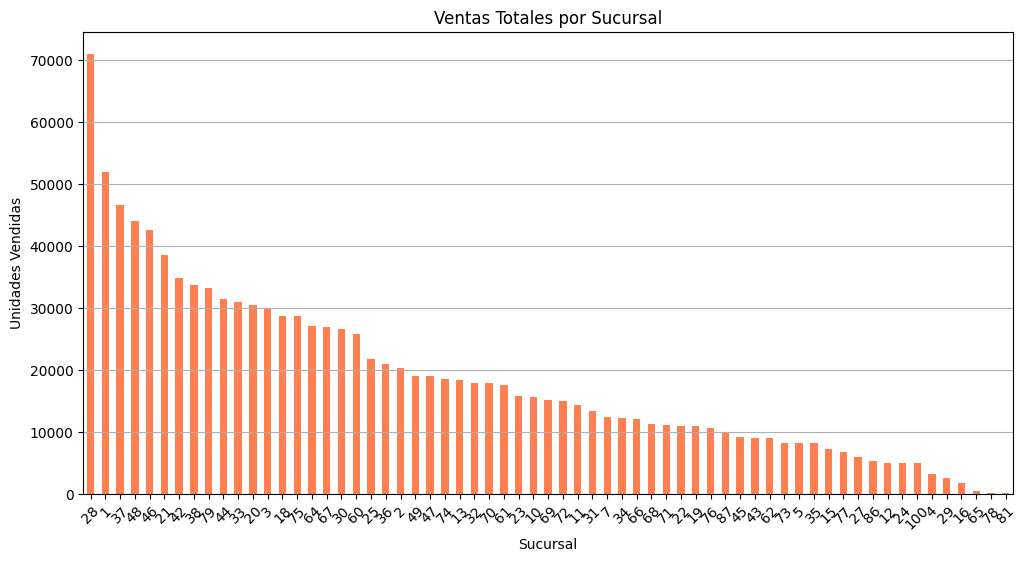

<Figure size 1200x600 with 0 Axes>

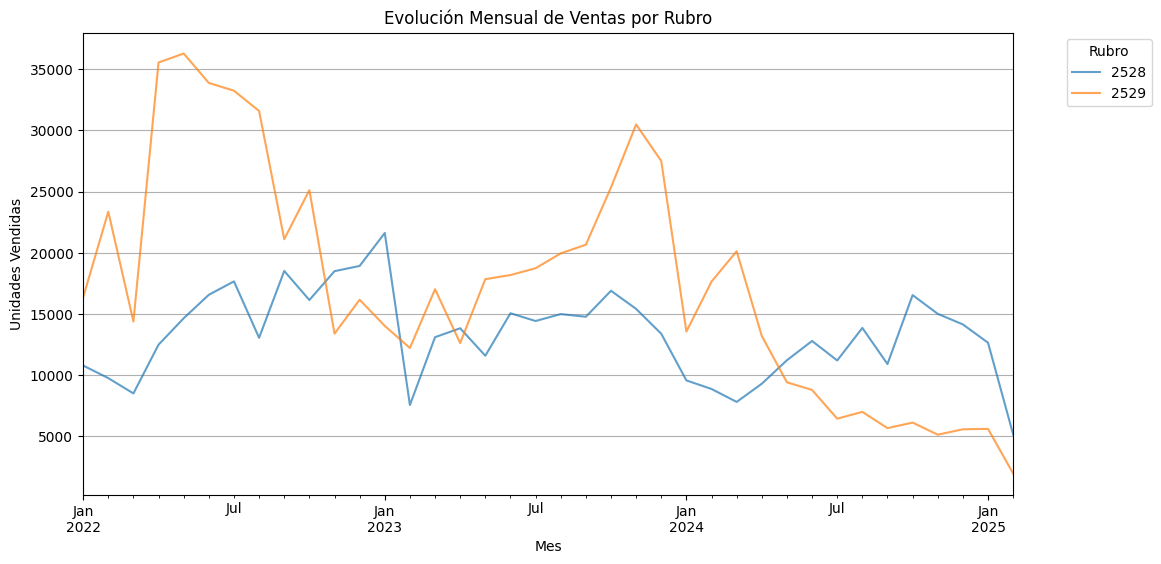

<Figure size 1200x600 with 0 Axes>

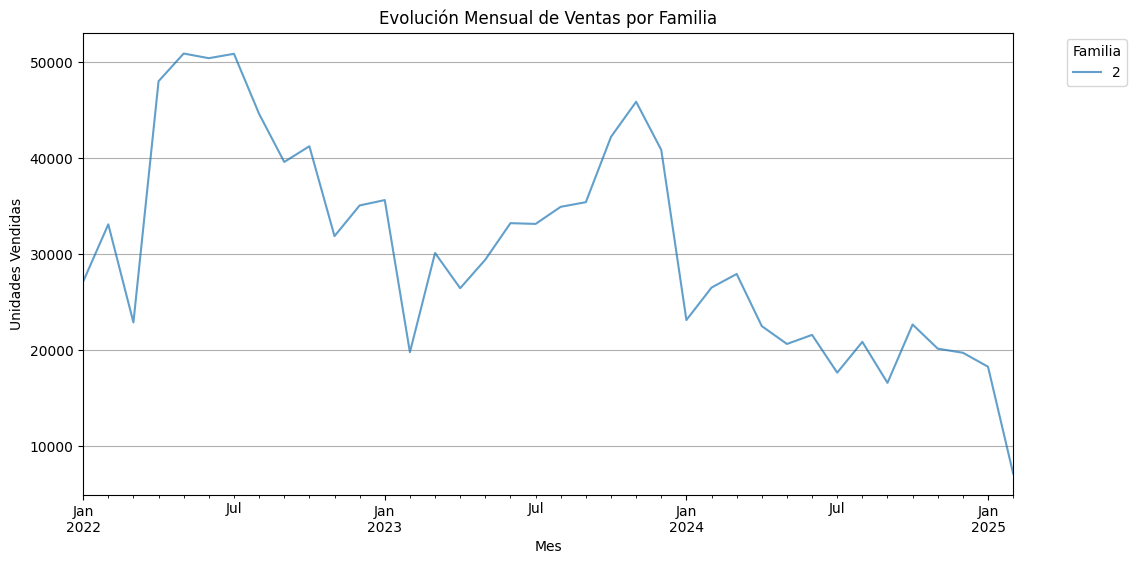

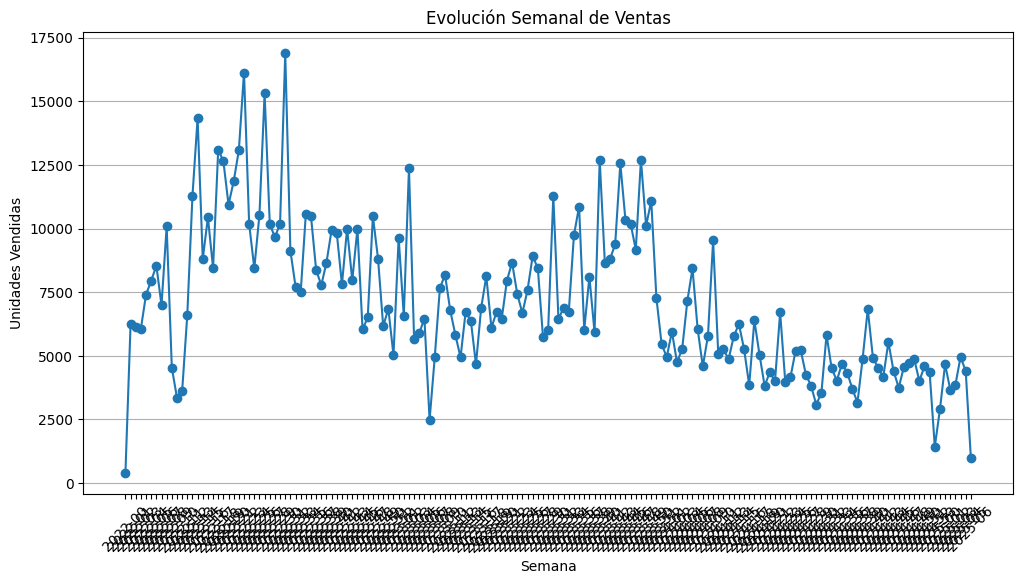

<Figure size 1200x600 with 0 Axes>

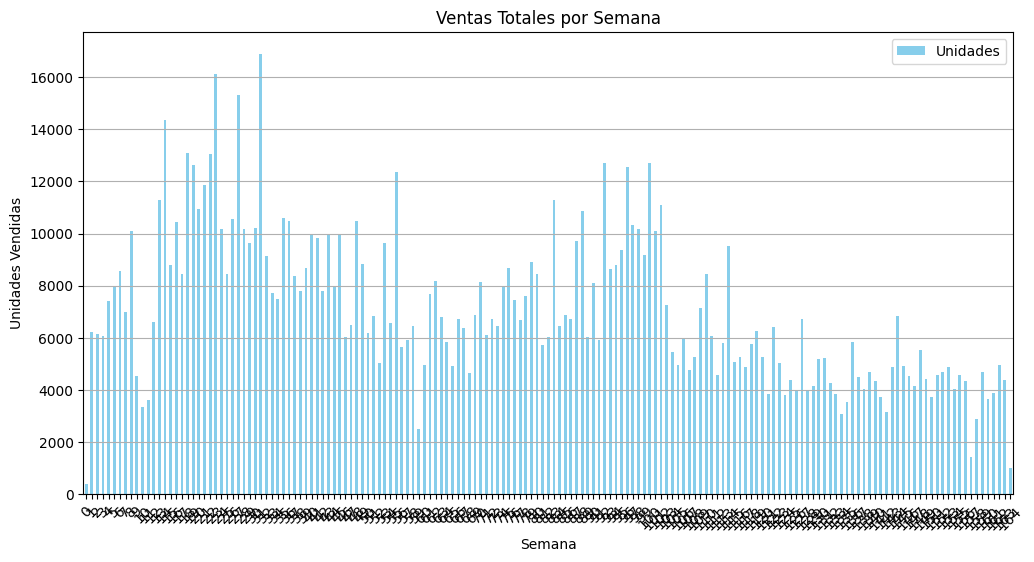

In [13]:
# 1. Ventas Totales por Mes
ventas_mensuales = data.groupby('Año-Mes')['Unidades'].sum()

plt.figure(figsize=(12, 6))
ventas_mensuales.plot(kind='bar', color='skyblue')
plt.title('Ventas Totales por Mes')
plt.xlabel('Mes')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 2. Ventas Totales por Artículo y por Mes (usando Nombre_Articulo)
ventas_articulo_mes = data.groupby(['Año-Mes', 'Nombre_Articulo'])['Unidades'].sum().unstack()

plt.figure(figsize=(12, 6))
ventas_articulo_mes.plot(kind='line', figsize=(12, 6), alpha=0.7)
plt.title('Evolución de Ventas por Artículo y por Mes')
plt.xlabel('Mes')
plt.ylabel('Unidades Vendidas')
plt.legend(title='Artículo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# 3. Ventas por Sucursal
ventas_sucursal = data.groupby('Sucursal')['Unidades'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ventas_sucursal.plot(kind='bar', color='coral')
plt.title('Ventas Totales por Sucursal')
plt.xlabel('Sucursal')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 4. Ventas por mes y rubro
ventas_rubro_mes = data.groupby(['Año-Mes', 'Rubro'])['Unidades'].sum().unstack()

# Graficar la evolución mensual de ventas por rubro
plt.figure(figsize=(12, 6))
ventas_rubro_mes.plot(kind='line', figsize=(12, 6), alpha=0.7)
plt.title('Evolución Mensual de Ventas por Rubro')
plt.xlabel('Mes')
plt.ylabel('Unidades Vendidas')
plt.legend(title='Rubro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# 5. Ventas por mes y familia
ventas_familia_mes = data.groupby(['Año-Mes', 'Familia'])['Unidades'].sum().unstack()

# Graficar la evolución mensual de ventas por familia
plt.figure(figsize=(12, 6))
ventas_familia_mes.plot(kind='line', figsize=(12, 6), alpha=0.7)
plt.title('Evolución Mensual de Ventas por Familia')
plt.xlabel('Mes')
plt.ylabel('Unidades Vendidas')
plt.legend(title='Familia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


# 6, Ventas por semana
ventas_semanales = data.groupby('Año-Semana')['Unidades'].sum().reset_index()
# Formatear la columna 'Año-Semana' en el formato 'AAAA-WW'
ventas_semanales['Semana'] = ventas_semanales['Año-Semana'].astype(str).str[:4] + '-' + ventas_semanales['Año-Semana'].astype(str).str[-2:]

# Graficar la evolución semanal de ventas
plt.figure(figsize=(12, 6))
plt.plot(ventas_semanales['Año-Semana'].astype(str), ventas_semanales['Unidades'], marker='o', linestyle='-')
plt.title('Evolución Semanal de Ventas')
plt.xlabel('Semana')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 7. Graficar la evolución semanal de ventas.
#ventas_articulo_semana = data.groupby(['Año-Semana', 'Nombre_Articulo'])['Unidades'].sum().unstack()

plt.figure(figsize=(12, 6))
ventas_semanales.plot(kind='bar', figsize=(12, 6),color='skyblue')
plt.title('Ventas Totales por Semana')
plt.xlabel('Semana')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# Asegurar que las semanas están ordenadas correctamente
ventas_semanales = ventas_semanales.sort_index()

# Graficar la evolución semanal de ventas por artículo con semanas ordenadas
plt.figure(figsize=(12, 6))
ventas_semanales.plot(kind='line', figsize=(12, 6), alpha=0.7)
plt.title('Evolución Semanal de Ventas por Artículo')
plt.xlabel('Semana (AAAA-WW)')
plt.ylabel('Unidades Vendidas')
plt.xticks(rotation=45)
plt.legend(title='Artículo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# Agrupar las ventas por mes y formato
ventas_formato_mes = data.groupby(['Año-Semana', 'formato'])['Unidades'].sum().unstack()

# Graficar la evolución mensual de ventas por formato
plt.figure(figsize=(12, 6))
ventas_formato_mes.plot(kind='line', figsize=(12, 6), alpha=0.7)
plt.title('Evolución Mensual de Ventas por Formato')
plt.xlabel('Semana (AAAA-WW)')
plt.ylabel('Unidades Vendidas')
plt.legend(title='Formato', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()



# Evaluación de Algoritmos para la Estimación de la Demanda
   Este Notebook tiene como objetivo evaluar distintos enfoques para la estimación de la demanda a partir de datos históricos de ventas. Se abordan procesos de análisis exploratorio, preprocesamiento, modelado y evaluación de modelos. Los ejemplos presentados incluyen métodos estadísticos (ARIMA y Holt-Winters) y un modelo de Machine Learning (Random Forest).

In [ ]:
# Importación de librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

#Habilita el Renderizado debajo de la celda
%matplotlib inline   
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Carga y Exploración Inicial de los Datos

Se asume que los datos se encuentran en un archivo CSV denominado `ventas.csv`. En esta sección se carga el archivo y se realizan inspecciones preliminares

In [ ]:
# Carga de datos
df = data

# Mostrar resultado
import ace_tools_open  as tools
tools.display_dataframe_to_user(name="DataFrame Básico", dataframe=df)

# Visualización de las primeras filas\
df.head()

# Información general del dataframe
print(df.info())

# Estadísticas descriptivas
print(df.describe())

In [ ]:
import pandas as pd
import numpy as np

def forecast_basic(df, current_date, period_length=30):
    """
    Calcula la demanda estimada utilizando el algoritmo básico.

    Parámetros:
    - df: DataFrame de pandas con la información histórica de ventas.
    - current_date: Fecha de referencia para el cálculo.
    - period_length: Número de días que conforman el período (por defecto 30).

    El algoritmo utiliza tres períodos:
      1. Últimos 'period_length' días: desde current_date - (period_length - 1) hasta current_date.
      2. Los 'period_length' días anteriores: desde current_date - (2*period_length - 1) hasta current_date - period_length.
      3. El mismo período del año anterior: desde current_date - 1 año - (period_length - 1) hasta current_date - 1 año.

    La demanda estimada se calcula como el promedio de las ventas en estos tres períodos.
    """
    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=period_length - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * period_length - 1)
    previous_period_end = current_date - pd.Timedelta(days=period_length)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=period_length - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                  .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})

    # Unir la información de los tres períodos
    forecast_df = pd.merge(sales_last, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='outer')
    forecast_df = pd.merge(forecast_df, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='outer')
    forecast_df.fillna(0, inplace=True)

    # Calcular la demanda estimada como el promedio de las ventas de los tres períodos
    forecast_df['forecast'] = (forecast_df['ventas_last'] +
                               forecast_df['ventas_previous'] +
                               forecast_df['ventas_same_year']) / 3

    # Redondear la predicción al entero más cercano
    forecast_df['forecast'] = forecast_df['forecast'].round().astype(int)

    return forecast_df

def evaluate_forecast(forecast_df, actual_df, merge_keys=['Codigo_Articulo', 'Sucursal']):
    """
    Evalúa la precisión del algoritmo de predicción calculando métricas de error.

    Parámetros:
    - forecast_df: DataFrame con las predicciones (debe incluir la columna 'forecast').
    - actual_df: DataFrame con las ventas reales (debe incluir la columna 'actual').
    - merge_keys: Lista de columnas en las que se realizará la unión de ambos DataFrames.

    Retorna un diccionario con las métricas MAE, MSE y MAPE.
    """
    # Unir las predicciones con los valores reales
    merged = pd.merge(forecast_df, actual_df, on=merge_keys, how='inner')

    # Calcular las métricas de error
    mae = np.mean(np.abs(merged['forecast'] - merged['actual']))
    mse = np.mean((merged['forecast'] - merged['actual'])**2)
    # Se añade un valor pequeño para evitar división por cero
    mape = np.mean(np.abs((merged['forecast'] - merged['actual']) / (merged['actual'] + 1e-9))) * 100

    return {'MAE': mae, 'MSE': mse, 'MAPE': mape}

def get_forecast(df, algorithm='basic', current_date=None, period_length=30):
    """
    Permite la selección del algoritmo de predicción y calcula la demanda estimada.

    Parámetros:
    - df: DataFrame con la información histórica.
    - algorithm: Algoritmo a utilizar (por defecto 'basic').
    - current_date: Fecha de referencia para el cálculo; si es None, se toma la fecha máxima del DataFrame.
    - period_length: Número de días del período a analizar.

    Retorna un DataFrame con las predicciones.
    """
    if current_date is None:
        current_date = df['Fecha'].max()

    if algorithm == 'basic':
        forecast_df = forecast_basic(df, current_date, period_length)
    else:
        raise ValueError(f"El algoritmo '{algorithm}' no está implementado.")

    return forecast_df


In [ ]:
# Ejemplo de uso del programa
if __name__ == '__main__':
    # Se asume que se dispone de un DataFrame 'df' con la información histórica,
    # por ejemplo, cargado desde un archivo CSV:
    # df = pd.read_csv('datos_ventas.csv', parse_dates=['Fecha'])
    
    # Para efectos ilustrativos, se crea un DataFrame de ejemplo con datos ficticios.
    # fechas = pd.date_range(start='2024-01-01', end='2025-02-10', freq='D')
    # data = {
    #     'Fecha': np.random.choice(fechas, 1000),
    #     'Codigo_Articulo': np.random.randint(1000, 1020, size=1000),
    #     'Sucursal': np.random.randint(1, 5, size=1000),
    #     'Precio': np.random.uniform(100, 1000, size=1000),
    #     'Costo': np.random.uniform(80, 900, size=1000),
    #     'Unidades': np.random.randint(1, 10, size=1000),
    #     'Familia': np.random.randint(1, 3, size=1000),
    #     'Rubro': np.random.randint(1, 3, size=1000),
    #     'SubRubro': np.random.randint(1, 3, size=1000),
    #     'Nombre_Articulo': ['Articulo ' + str(i) for i in range(1000, 2000)][:1000],
    #     'Clasificacion': np.random.randint(1, 5, size=1000),
    #     'Año-Mes': pd.PeriodIndex(pd.to_datetime(np.random.choice(fechas, 1000)), freq='M'),
    #     'Año-Semana': ['2024-S' + str(np.random.randint(1, 53)) for _ in range(1000)],
    #     'id_tienda': np.random.randint(1, 5, size=1000),
    #     'formato': np.random.choice(['Formato1', 'Formato2'], size=1000),
    #     'Dia_Semana': np.random.randint(0, 7, size=1000),
    #     'Semana_Año': np.random.randint(1, 53, size=1000)
    # }
    # df = pd.DataFrame(data)
    
    # Calcular la demanda estimada utilizando el algoritmo básico
    forecast_result = get_forecast(df, algorithm='basic', period_length=30)
    
    # Mostrar un ejemplo de resultados
    print("Demanda estimada utilizando el algoritmo básico:")
    print(forecast_result.head())
    
    # Para evaluar la precisión del algoritmo, se requiere disponer de un DataFrame 'actual_df'
    # con los datos reales de ventas para el mismo período (columna 'actual').
    # Por ejemplo:
    # actual_df = pd.read_csv('ventas_reales.csv', parse_dates=['Fecha'])
    # metrics = evaluate_forecast(forecast_result, actual_df)
    # print("Métricas de evaluación:", metrics)

## Análisis Exploratorio de Datos (EDA)

En esta sección se analiza la distribución de las ventas, se detectan posibles valores nulos o atípicos, y se estudia la evolución temporal de la demanda.

In [ ]:
## Agregar DATOS de DIA SEMANA y SEMANA AÑO

df['Dia_Semana'] = df['Fecha'].dt.weekday

df['Semana_Año'] = df['Fecha'].dt.isocalendar().week

In [ ]:
df = df[df.index >='2024-01-01']

In [ ]:
df.columns.str.strip()

In [ ]:
df.head()


In [ ]:
# Comprobación de valores nulos
print('Valores nulos por columna:')
print(df.isnull().sum())

# Análisis de la distribución de ventas (Unidades)
plt.figure(figsize=(10, 6))
sns.histplot(df['Unidades'], bins=50, kde=True)
plt.title('Distribución de Ventas (Unidades)')
plt.xlabel('Unidades')
plt.ylabel('Frecuencia')
plt.show()

# Evolución de ventas a lo largo del tiempo (agrupado por fecha)
ventas_diarias = df.groupby('Fecha')['Unidades'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(ventas_diarias['Fecha'], ventas_diarias['Unidades'], label='Ventas Diarias')
plt.title('Evolución de Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.show()

## Preprocesamiento y Transformación de los Datos

Se procede a convertir la columna `Fecha` en el índice del dataframe. Además, se selecciona un ejemplo representativo (un artículo y una tienda) para realizar la predicción. Posteriormente, se agrupan las ventas por día y se generan variables derivadas (lags y medias móviles) para enriquecer la información de entrada."

In [ ]:
# Convertir la columna 'Fecha' en índice
#df.set_index('Fecha', inplace=True)

# Seleccionar un ejemplo: se elige un artículo y una tienda específicos
codigo_articulo_ej = df['Codigo_Articulo'].unique()[0]
sucursal_ej = df['Sucursal'].unique()[0]

df_ej = df[(df['Codigo_Articulo'] == codigo_articulo_ej) & (df['Sucursal'] == sucursal_ej)].copy()

# Agrupar las ventas por día
ventas_diarias_ej = df_ej['Unidades'].resample('D').sum().fillna(0)

print(ventas_diarias_ej.head())

### Creación de Variables (Feature Engineering)

Se generan variables de retardo (lag) y medias móviles para incorporar información histórica en el modelo de Machine Learning.

In [ ]:
df_model = ventas_diarias_ej.to_frame(name='Unidades')

# Crear variables de lag (por ejemplo, 1, 7 y 14 días)
for lag in [1, 7, 14]:
    df_model[f'lag_{lag}'] = df_model['Unidades'].shift(lag)

# Crear variable de media móvil de 7 días
df_model['rolling_mean_7'] = df_model['Unidades'].rolling(window=7).mean()

# Eliminar valores nulos generados por el lag y la media móvil
df_model.dropna(inplace=True)

print(df_model.head())

## División de Datos en Entrenamiento y Prueba

Se define un corte temporal para separar el conjunto en datos de entrenamiento y de prueba. En este ejemplo, se utiliza el último mes de datos como conjunto de prueba.

In [ ]:
train_end = df_model.index.max() - pd.Timedelta(days=30)
train_data = df_model.loc[:train_end]
test_data = df_model.loc[train_end + pd.Timedelta(days=1):]

print('Periodo de Entrenamiento:', train_data.index.min(), 'a', train_data.index.max())
print('Periodo de Prueba:', test_data.index.min(), 'a', test_data.index.max())

## Modelado

A continuación se presentan tres enfoques de modelado:

1. **ARIMA:** Modelo estadístico para series temporales.
2. **Holt-Winters:** Suavizamiento exponencial con componentes para tendencia y estacionalidad.
3. **Random Forest:** Modelo de Machine Learning basado en árboles de decisión, utilizando las variables derivadas.

### 1. Modelo ARIMA

Se ajusta un modelo ARIMA sobre la serie temporal de entrenamiento y se realizan predicciones para el conjunto de prueba.

In [ ]:
# Ajuste de un modelo ARIMA
# Se define el orden del modelo (p, d, q); este parámetro puede ser optimizado
arima_order = (1, 1, 1)

model_arima = ARIMA(train_data['Unidades'], order=arima_order)
model_arima_fit = model_arima.fit()

# Predicción sobre el conjunto de prueba
pred_arima = model_arima_fit.forecast(steps=len(test_data))

plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Unidades'], label='Entrenamiento')
plt.plot(test_data.index, test_data['Unidades'], label='Real')
plt.plot(test_data.index, pred_arima, label='Predicción ARIMA')
plt.title('Predicción con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

### 2. Modelo Holt-Winters (Exponential Smoothing)

Se utiliza el método de Holt-Winters para modelar la serie teniendo en cuenta la tendencia y la estacionalidad (con periodicidad semanal en este ejemplo)

In [ ]:
# Ajuste del modelo Holt-Winters
model_hw = ExponentialSmoothing(train_data['Unidades'], trend='add', seasonal='add', seasonal_periods=7)
model_hw_fit = model_hw.fit()

# Predicción sobre el conjunto de prueba
pred_hw = model_hw_fit.forecast(steps=len(test_data))

plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Unidades'], label='Entrenamiento')
plt.plot(test_data.index, test_data['Unidades'], label='Real')
plt.plot(test_data.index, pred_hw, label='Predicción Holt-Winters')
plt.title('Predicción con Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

### 3. Modelo de Machine Learning: Random Forest

Se entrena un modelo de Random Forest utilizando las variables de retardo y medias móviles obtenidas en el feature engineering.

In [ ]:
# Preparación de datos para el modelo de Machine Learning
features = [col for col in df_model.columns if col != 'Unidades']

X_train = train_data[features]
y_train = train_data['Unidades']

X_test = test_data[features]
y_test = test_data['Unidades']

# Entrenamiento del modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicción sobre el conjunto de prueba
pred_rf = rf_model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Unidades'], label='Entrenamiento')
plt.plot(test_data.index, y_test, label='Real')
plt.plot(test_data.index, pred_rf, label='Predicción Random Forest')
plt.title('Predicción con Random Forest')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

## Evaluación de Resultados

Se calculan las principales métricas de error para cada uno de los modelos: RMSE, MAE y MAPE. Esto permitirá comparar objetivamente el desempeño de los distintos enfoques.

In [ ]:
# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluación ARIMA
rmse_arima = sqrt(mean_squared_error(test_data['Unidades'], pred_arima))
mae_arima = mean_absolute_error(test_data['Unidades'], pred_arima)
mape_arima = mean_absolute_percentage_error(test_data['Unidades'], pred_arima)

print('ARIMA:')
print(f'RMSE: {rmse_arima:.2f}')
print(f'MAE: {mae_arima:.2f}')
print(f'MAPE: {mape_arima:.2f}%')

# Evaluación Holt-Winters
rmse_hw = sqrt(mean_squared_error(test_data['Unidades'], pred_hw))
mae_hw = mean_absolute_error(test_data['Unidades'], pred_hw)
mape_hw = mean_absolute_percentage_error(test_data['Unidades'], pred_hw)

print('\\nHolt-Winters:')
print(f'RMSE: {rmse_hw:.2f}')
print(f'MAE: {mae_hw:.2f}')
print(f'MAPE: {mape_hw:.2f}%')

# Evaluación Random Forest
rmse_rf = sqrt(mean_squared_error(y_test, pred_rf))
mae_rf = mean_absolute_error(y_test, pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, pred_rf)

print('\\nRandom Forest:')
print(f'RMSE: {rmse_rf:.2f}')
print(f'MAE: {mae_rf:.2f}')
print(f'MAPE: {mape_rf:.2f}%')

In [ ]:
def smape(y_true, y_pred):
    # Convertir a arrays de NumPy para facilitar las operaciones vectorizadas
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Calcular el denominador de la fórmula: suma de los valores absolutos de y_true y y_pred
    denominator = np.abs(y_true) + np.abs(y_pred)
    # Evitar la división por cero: donde el denominador es cero, se asigna 0 (ya que 0/0 se considera error nulo en este contexto)
    smape_values = np.where(denominator == 0, 0, 2.0 * np.abs(y_true - y_pred) / denominator)
    # Calcular el SMAPE medio y multiplicar por 100 para expresarlo en porcentaje
    return np.mean(smape_values) * 100

# Reemplazar la línea original de MAPE por la siguiente:
smape_arima = smape(test_data['Unidades'], pred_arima)
smape_hw = smape(test_data['Unidades'], pred_hw)
smape_rf = smape(y_test, pred_rf)


print('\\Metricas SMAPE:')
print(f'Ramdon Forest: {smape_rf:.2f}')
print(f'Holt Winters: {smape_hw:.2f}')
print(f'ARIMA: {smape_arima:.2f}%')

## Conclusiones y Siguientes Pasos

El presente Notebook demuestra un enfoque integral para la evaluación de diferentes algoritmos de predicción de la demanda. Se recomienda continuar con la optimización de hiperparámetros, explorar modelos adicionales (incluyendo técnicas de deep learning y métodos de ensemble) y, finalmente, integrar el pipeline en el sistema de reposición automática para su validación en un entorno real.

El grupo de trabajo puede beneficiarse de incluir variables que representen tanto el día de la semana como la semana del año, ya que ambas permiten capturar diferentes niveles de estacionalidad y patrones cíclicos en los datos. En particular:

### Día de la semana:
La incorporación de esta variable puede ser especialmente útil para capturar efectos a corto plazo. En muchos entornos, especialmente en el sector retail, se observa que la demanda varía significativamente entre días laborables y fines de semana. Por ejemplo, es común que se registren picos de ventas en ciertos días (por ejemplo, durante el fin de semana o en días con promociones especiales). Esta variable, al ser de naturaleza categórica, puede incluirse mediante codificación dummy o utilizando transformaciones que permitan capturar dichas variaciones.

### Semana del año:
La variable que indica la semana del año ayuda a identificar patrones de largo plazo y tendencias estacionales que se repiten anualmente, tales como las variaciones propias de temporadas de vacaciones, festividades o campañas estacionales. Este enfoque resulta relevante cuando la demanda presenta fluctuaciones significativas a lo largo del año, permitiendo al modelo ajustarse a estas variaciones y mejorar la precisión en periodos específicos.

El grupo de trabajo deberá, a partir de un análisis exploratorio de los datos, determinar cuál de estas variables (o la combinación de ambas) aporta mayor valor predictivo. Es importante tener en cuenta que la inclusión simultánea de ambas puede aportar información complementaria, pero también podría generar redundancias o problemas de multicolinealidad si las dos variables están altamente correlacionadas. Por ello, se recomienda realizar pruebas empíricas y análisis de sensibilidad para validar la utilidad de cada variable en el contexto específico de la demanda a estimar.

## Opinión GENERAL
La incorporación tanto del día de la semana como de la semana del año suele resultar ventajosa, siempre que se respalde con un análisis previo que confirme la existencia de patrones estacionales a diferentes escalas temporales. Se sugiere lo siguiente:

### Evaluación empírica:
Es recomendable que el grupo de trabajo realice un análisis de descomposición de la serie temporal para identificar si existen patrones estacionales diarios o anuales. De esta forma, se podrá determinar si los cambios en la demanda se relacionan de forma consistente con días específicos de la semana o si existen fluctuaciones a nivel semanal que justifiquen la inclusión de la semana del año.

### Manejo de la multicolinealidad:
En caso de que ambas variables muestren una correlación alta, podría ser prudente aplicar técnicas de reducción de dimensionalidad o selección de variables para evitar redundancias en el modelo, lo que permitirá que la predicción sea más robusta y que se maximice la capacidad explicativa del conjunto de variables.

### Flexibilidad del modelo:
La combinación de ambas variables puede aportar un mayor grado de precisión al modelo de predicción, ya que permite captar tanto las variaciones de corto plazo (día a día) como las tendencias de largo plazo (ciclo anual). Esto es especialmente relevante en contextos donde la demanda se ve influenciada por factores operativos diarios y por eventos estacionales o promocionales.

En resumen, ChatGPT opina que, de implementarse correctamente y tras una adecuada validación empírica, la inclusión de estas variables estacionales puede mejorar significativamente el rendimiento predictivo del modelo, ofreciendo una visión más completa y adaptada a los patrones inherentes a la demanda.